<a href="https://colab.research.google.com/github/aminpaw/FSAI_CONTROL/blob/main/LQR_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install quadprog

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import numpy as np
import math
import quadprog
import time
import math
from scipy import interpolate,optimize,spatial 
from typing import Union
import scipy.interpolate

def calcSplines(path: np.ndarray,
                 psi_s: float = None,
                 psi_e: float = None,
                 use_dist_scaling: bool = True) -> tuple:

    t_start = time.perf_counter() 

    # get number of splines
    noSplines = path.shape[0] - 1

    scaling = np.ones(noSplines - 1)

    # M_{x,y} * a_{x,y} = b_{x,y}) (a{x,y} = )
    # *4 because of 4 parameters in cubic spline
    M = np.zeros((noSplines * 4, noSplines * 4))
    b_x = np.zeros((noSplines * 4, 1))
    b_y = np.zeros((noSplines * 4, 1))

    # create template for M array entries
    # row 1: beginning of current spline should be placed on current point (t = 0)
    # row 2: end of current spline should be placed on next point (t = 1)
    # row 3: heading at end of current spline should be equal to heading at beginning of next spline (t = 1 and t = 0)
    # row 4: curvature at end of current spline should be equal to curvature at beginning of next spline (t = 1 and t = 0)
    templateM = np.array(                          # current point               | next point              
                [[1,  0,  0,  0,  0,  0,  0,  0],   # a_0i                                                  
                 [1,  1,  1,  1,  0,  0,  0,  0],   # a_0i + a_1i +  a_2i +  a_3i                           
                 [0,  1,  2,  3,  0, -1,  0,  0],   # _      a_1i + 2a_2i + 3a_3i      - a_1i+1             
                 [0,  0,  2,  6,  0,  0, -2,  0]])  # _             2a_2i + 6a_3i               - 2a_2i+1   

    for i in range(noSplines):
        j = i * 4

        if i < noSplines - 1:
            M[j: j + 4, j: j + 8] = templateM

            M[j + 2, j + 5] *= scaling[i]
            M[j + 3, j + 6] *= math.pow(scaling[i], 2)

        else:
            # no curvature and heading bounds on last element
            M[j: j + 2, j: j + 4] = [[1,  0,  0,  0],
                                     [1,  1,  1,  1]]

        b_x[j: j + 2] = [[path[i,     0]],
                         [path[i + 1, 0]]]
        b_y[j: j + 2] = [[path[i,     1]],
                         [path[i + 1, 1]]]

    # ------------------------------------------------------------------------------------------------------------------
    # SET BOUNDARY CONDITIONS FOR LAST AND FIRST POINT -----------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    # heading boundary condition
    M[-2, 1] = scaling[-1]
    M[-2, -3:] = [-1, -2, -3]
    # curvature boundary condition
    M[-1, 2] = 2 * math.pow(scaling[-1], 2)
    M[-1, -2:] = [-2, -6]
    print("TIME BEFORE CALC: ",time.perf_counter()-t_start)
    # ------------------------------------------------------------------------------------------------------------------
    # SOLVE ------------------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------
    #xLinearEquations = np.squeeze(np.linalg.solve(M, b_x))  # squeeze removes single-dimensional entries
    #yLinearEquations= np.squeeze(np.linalg.solve(M, b_y))
    t = np.arange(0,path.shape[0])
    x = np.array(path[:,0])
    y = np.array(path[:,1])
    x_s = interpolate.CubicSpline(t,x)
    y_s = interpolate.CubicSpline(t,y)
    xCoeffs = np.rot90(x_s.c, 3)
    yCoeffs = np.rot90(y_s.c, 3)
    print("TIME AFTER CALC: ", -t_start + time.perf_counter())
    # get coefficients of every piece into one row -> reshape
    #xCoeffs = np.reshape(xLinearEquations, (noSplines, 4))
    #yCoeffs = np.reshape(yLinearEquations, (noSplines, 4))

    # get normal vector 
    normVec = np.stack((yCoeffs[:, 1], -xCoeffs[:, 1]), axis=1)

    # normalize normal vectors
    normFactors = 1.0 / np.sqrt(np.sum(np.power(normVec, 2), axis=1))
    normVecNormalized = np.expand_dims(normFactors, axis=1) * normVec
    print("END: ", -t_start + time.perf_counter())
    return xCoeffs, yCoeffs, M, normVecNormalized

def opt_min_curv(reftrack: np.ndarray,
                 normvectors: np.ndarray,
                 A: np.ndarray,
                 vehicleWidth,
                 kappa_bound: float = 0.2) -> tuple:
    TS = time.perf_counter()
    # ------------------------------------------------------------------------------------------------------------------
    # PREPARATIONS -----------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------
    TimeS = time.perf_counter()
    noPoints = reftrack.shape[0]

    noSplines = noPoints

    # create extraction matrix -for b_i coefficients used in gradient
    A_ex_b = np.zeros((noPoints, noSplines * 4), dtype=int)

    for i in range(noSplines):
        A_ex_b[i, i * 4 + 1] = 1    # 1 * b_ix = E_x * x

    # create extraction matrix -> only c_i coefficients of the solved linear equation system are needed for curvature
    # information
    A_ex_c = np.zeros((noPoints, noSplines * 4), dtype=int)

    for i in range(noSplines):
        A_ex_c[i, i * 4 + 2] = 2    # 2 * c_ix = D_x * x

    Time_S = time.perf_counter()
    # invert matrix A resulting from the spline setup linear equation system and apply extraction matrix
    A_inv = np.linalg.inv(A)
    T_c = np.matmul(A_ex_c, A_inv)
    print("SUS: ", -Time_S + time.perf_counter())
    # set up M_x and M_y matrices 
    M_x = np.zeros((noSplines * 4, noPoints))
    M_y = np.zeros((noSplines * 4, noPoints))

    for i in range(noSplines):
        j = i * 4

        if i < noPoints - 1:
            M_x[j, i] = normvectors[i, 0]
            M_x[j + 1, i + 1] = normvectors[i + 1, 0]

            M_y[j, i] = normvectors[i, 1]
            M_y[j + 1, i + 1] = normvectors[i + 1, 1]
        else:
            M_x[j, i] = normvectors[i, 0]
            M_x[j + 1, 0] = normvectors[0, 0]  # close spline

            M_y[j, i] = normvectors[i, 1]
            M_y[j + 1, 0] = normvectors[0, 1]

    # set up q_x and q_y matrices including the point coordinate information
    q_x = np.zeros((noSplines * 4, 1))
    q_y = np.zeros((noSplines * 4, 1))

    for i in range(noSplines):
        j = i * 4

        if i < noPoints - 1:
            q_x[j, 0] = reftrack[i, 0]
            q_x[j + 1, 0] = reftrack[i + 1, 0]

            q_y[j, 0] = reftrack[i, 1]
            q_y[j + 1, 0] = reftrack[i + 1, 1]
        else:
            q_x[j, 0] = reftrack[i, 0]
            q_x[j + 1, 0] = reftrack[0, 0]

            q_y[j, 0] = reftrack[i, 1]
            q_y[j + 1, 0] = reftrack[0, 1]

    # set up P_xx, P_xy, P_yy matrices
    x_prime = np.eye(noPoints, noPoints) * np.matmul(np.matmul(A_ex_b, A_inv), q_x)
    y_prime = np.eye(noPoints, noPoints) * np.matmul(np.matmul(A_ex_b, A_inv), q_y)

    x_prime_sq = np.power(x_prime, 2)
    y_prime_sq = np.power(y_prime, 2)
    x_prime_y_prime = -2 * np.matmul(x_prime, y_prime)

    curv_den = np.power(x_prime_sq + y_prime_sq, 1.5)                   # calculate curvature denominator
    curv_part = np.divide(1, curv_den, out=np.zeros_like(curv_den),
                          where=curv_den != 0)                          # divide where not zero (diag elements)
    curv_part_sq = np.power(curv_part, 2)

    P_xx = np.matmul(curv_part_sq, y_prime_sq)
    P_yy = np.matmul(curv_part_sq, x_prime_sq)
    P_xy = np.matmul(curv_part_sq, x_prime_y_prime)
    print(-TimeS + time.perf_counter())
    # ------------------------------------------------------------------------------------------------------------------
    # SET UP FINAL MATRICES FOR SOLVER ---------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------
    TimeS = time.perf_counter()
    T_nx = np.matmul(T_c, M_x)
    T_ny = np.matmul(T_c, M_y)

    H_x = np.matmul(T_nx.T, np.matmul(P_xx, T_nx))
    H_xy = np.matmul(T_ny.T, np.matmul(P_xy, T_nx))
    H_y = np.matmul(T_ny.T, np.matmul(P_yy, T_ny))
    H = H_x + H_xy + H_y
    H = (H + H.T) / 2   # make H symmetric(because solver used needs symmetrical)

    f_x = 2 * np.matmul(np.matmul(q_x.T, T_c.T), np.matmul(P_xx, T_nx))
    f_xy = np.matmul(np.matmul(q_x.T, T_c.T), np.matmul(P_xy, T_ny)) \
           + np.matmul(np.matmul(q_y.T, T_c.T), np.matmul(P_xy, T_nx))
    f_y = 2 * np.matmul(np.matmul(q_y.T, T_c.T), np.matmul(P_yy, T_ny))
    f = f_x + f_xy + f_y
    f = np.squeeze(f)   # remove non-singleton dimensions
    print(-TimeS + time.perf_counter())
    # ------------------------------------------------------------------------------------------------------------------
    # CURVATURE(KAPPA) CONSTRAINTS ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------
    TimeS = time.perf_counter()
    Q_x = np.matmul(curv_part, y_prime)
    Q_y = np.matmul(curv_part, x_prime)

    # this part is multiplied by alpha within the optimization 
    E_kappa = np.matmul(Q_y, T_ny) - np.matmul(Q_x, T_nx)

    # original curvature part (static part)
    k_kappa_ref = np.matmul(Q_y, np.matmul(T_c, q_y)) - np.matmul(Q_x, np.matmul(T_c, q_x))

    con_ge = np.ones((noPoints, 1)) * kappa_bound - k_kappa_ref
    con_le = -(np.ones((noPoints, 1)) * -kappa_bound - k_kappa_ref)  
    con_stack = np.append(con_ge, con_le)
    print(-TimeS + time.perf_counter())
    print("BEFORE OPT.: ",- TS + time.perf_counter())
    # ------------------------------------------------------------------------------------------------------------------
    # SOLVE COST FUNCTION -----------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    """
    Solve a Quadratic Program defined as:
        minimize
            (1/2) * alpha.T * H * alpha + f.T * alpha
        subject to
            G * alpha <= h
    """

    # calculate allowed deviation from refline
    dev_max_right = reftrack[:, 2] -(vehicleWidth / 2) 
    dev_max_left = reftrack[:, 3] - (vehicleWidth / 2 )

    # consider value boundaries (-dev_max_left <= alpha <= dev_max_right)
    G = np.vstack((np.eye(noPoints), -np.eye(noPoints), E_kappa, -E_kappa))  
    h = np.append(dev_max_right, dev_max_left)
    h = np.append(h, con_stack)

    # save start time
    t_start = time.perf_counter()

    # solve problem -----------------------------------------------------------------------------------------
    alpha_mincurv = quadprog.solve_qp(H, -f, -G.T, -h, 0)[0]

    print("Solver runtime opt_min_curv: " + "{:.3f}".format(time.perf_counter() - t_start) + "s")

    return alpha_mincurv 

def prep_track(reftrack_imp: np.ndarray,
        reg_smooth_opts={"k_reg": 3,"s_reg": 10},
        stepsize_opts={"stepsize_prep": 1.0,"stepsize_reg": 3.0,"stepsize_interp_after_opt": 2.0},
        debug: bool = True,
        min_width: float = 3) -> tuple:

    # smoothing and interpolating reference track
    reftrack_interp = spline_approximation(track=reftrack_imp,
                             k_reg=reg_smooth_opts["k_reg"],
                             s_reg=reg_smooth_opts["s_reg"],
                             stepsize_prep=stepsize_opts["stepsize_prep"],
                             stepsize_reg=stepsize_opts["stepsize_reg"])

    # calculate splines
    refpath_interp_cl = np.vstack((reftrack_interp[:, :2], reftrack_interp[0, :2]))
    coeffs_x_interp, coeffs_y_interp, a_interp, normvec_normalized_interp = calcSplines(path=refpath_interp_cl)

    if min_width is not None:
        for i in range(reftrack_interp.shape[0]):
            cur_width = reftrack_interp[i, 2] + reftrack_interp[i, 3]

            if cur_width < min_width:

                # inflate to both sides equally
                reftrack_interp[i, 2] += (min_width - cur_width) / 2
                reftrack_interp[i, 3] += (min_width - cur_width) / 2

    return reftrack_interp, normvec_normalized_interp, a_interp, coeffs_x_interp, coeffs_y_interp

def spline_approximation(track: np.ndarray,
                         k_reg: int = 3,
                         s_reg: int = 10,
                         stepsize_prep: float = 1.0,
                         stepsize_reg: float = 3.0) -> np.ndarray:


    # ------------------------------------------------------------------------------------------------------------------
    # LINEAR INTERPOLATION BEFORE SMOOTHING ----------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    track_interp = interp_track(track=track, stepsize=stepsize_prep)
    print(track_interp)
    track_interp_cl = np.vstack((track_interp, track_interp[0]))

    # ------------------------------------------------------------------------------------------------------------------
    # SPLINE APPROXIMATION / PATH SMOOTHING ----------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    # create closed track (original track)
    track_cl = np.vstack((track, track[0]))
    no_points_track_cl = track_cl.shape[0]
    el_lengths_cl = np.sqrt(np.sum(np.power(np.diff(track_cl[:, :2], axis=0), 2), axis=1))
    dists_cum_cl = np.cumsum(el_lengths_cl)
    dists_cum_cl = np.insert(dists_cum_cl, 0, 0.0)

    # find B spline representation of the inserted path and smooth it in this process
    # (tck_cl: tuple (vector of knots, the B-spline coefficients, and the degree of the spline))
    tck_cl, t_glob_cl = interpolate.splprep([track_interp_cl[:, 0], track_interp_cl[:, 1]],
                                            k=k_reg,
                                            s=s_reg,
                                            per=1)[:2]

    # calculate total length of smooth approximating spline based on euclidian distance with points at every 0.25m
    no_points_lencalc_cl = math.ceil(dists_cum_cl[-1]) * 4
    path_smoothed_tmp = np.array(interpolate.splev(np.linspace(0.0, 1.0, no_points_lencalc_cl), tck_cl)).T
    len_path_smoothed_tmp = np.sum(np.sqrt(np.sum(np.power(np.diff(path_smoothed_tmp, axis=0), 2), axis=1)))

    # get smoothed path
    no_points_reg_cl = math.ceil(len_path_smoothed_tmp / stepsize_reg) + 1
    path_smoothed = np.array(interpolate.splev(np.linspace(0.0, 1.0, no_points_reg_cl), tck_cl)).T[:-1]

    # ------------------------------------------------------------------------------------------------------------------
    # PROCESS TRACK WIDTHS (AND BANKING ANGLE IF GIVEN) ----------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    # find the closest points on the B spline to input points
    dists_cl = np.zeros(no_points_track_cl)                 # contains (min) distances between input points and spline
    closest_point_cl = np.zeros((no_points_track_cl, 2))    # contains the closest points on the spline
    closest_t_glob_cl = np.zeros(no_points_track_cl)        # containts the t_glob values for closest points
    t_glob_guess_cl = dists_cum_cl / dists_cum_cl[-1]       # start guess for the minimization

    for i in range(no_points_track_cl):
        # get t_glob value for the point on the B spline with a minimum distance to the input points
        closest_t_glob_cl[i] = optimize.fmin(dist_to_p,
                                             x0=t_glob_guess_cl[i],
                                             args=(tck_cl, track_cl[i, :2]),
                                             disp=False)

        # evaluate B spline on the basis of t_glob to obtain the closest point
        closest_point_cl[i] = interpolate.splev(closest_t_glob_cl[i], tck_cl)

        # save distance from closest point to input point
        dists_cl[i] = math.sqrt(math.pow(closest_point_cl[i, 0] - track_cl[i, 0], 2)
                                + math.pow(closest_point_cl[i, 1] - track_cl[i, 1], 2))

    # get side of smoothed track compared to the inserted track
    sides = np.zeros(no_points_track_cl - 1)

    for i in range(no_points_track_cl - 1):
        sides[i] = side_of_line(a=track_cl[i, :2],
                                                 b=track_cl[i+1, :2],
                                                 z=closest_point_cl[i])

    sides_cl = np.hstack((sides, sides[0]))

    # calculate new track widths on the basis of the new reference line, but not interpolated to new stepsize yet
    w_tr_right_new_cl = track_cl[:, 2] + sides_cl * dists_cl
    w_tr_left_new_cl = track_cl[:, 3] - sides_cl * dists_cl

    # interpolate track widths after smoothing (linear)
    w_tr_right_smoothed_cl = np.interp(np.linspace(0.0, 1.0, no_points_reg_cl), closest_t_glob_cl, w_tr_right_new_cl)
    w_tr_left_smoothed_cl = np.interp(np.linspace(0.0, 1.0, no_points_reg_cl), closest_t_glob_cl, w_tr_left_new_cl)

    track_reg = np.column_stack((path_smoothed, w_tr_right_smoothed_cl[:-1], w_tr_left_smoothed_cl[:-1]))

    # interpolate banking if given (linear)
    if track_cl.shape[1] == 5:
        banking_smoothed_cl = np.interp(np.linspace(0.0, 1.0, no_points_reg_cl), closest_t_glob_cl, track_cl[:, 4])
        track_reg = np.column_stack((track_reg, banking_smoothed_cl[:-1]))

    return track_reg

def interp_track(track: np.ndarray,
                 stepsize: float) -> np.ndarray:
    
    #Interpolate track points linearly to a new stepsize.

    # create closed track
    track_cl = np.vstack((track, track[0]))

    # calculate element lengths (euclidian distance)
    el_lengths_cl = np.sqrt(np.sum(np.power(np.diff(track_cl[:, :2], axis=0), 2), axis=1))

    # sum up total distance (from start) to every element
    dists_cum_cl = np.cumsum(el_lengths_cl)
    dists_cum_cl = np.insert(dists_cum_cl, 0, 0.0)

    # calculate desired lenghts depending on specified stepsize (+1 because last element is included)
    no_points_interp_cl = math.ceil(dists_cum_cl[-1] / stepsize) + 1
    dists_interp_cl = np.linspace(0.0, dists_cum_cl[-1], no_points_interp_cl)

    # interpolate closed track points
    track_interp_cl = np.zeros((no_points_interp_cl, track_cl.shape[1]))

    track_interp_cl[:, 0] = np.interp(dists_interp_cl, dists_cum_cl, track_cl[:, 0])
    track_interp_cl[:, 1] = np.interp(dists_interp_cl, dists_cum_cl, track_cl[:, 1])
    track_interp_cl[:, 2] = np.interp(dists_interp_cl, dists_cum_cl, track_cl[:, 2])
    track_interp_cl[:, 3] = np.interp(dists_interp_cl, dists_cum_cl, track_cl[:, 3])

    if track_cl.shape[1] == 5:
        track_interp_cl[:, 4] = np.interp(dists_interp_cl, dists_cum_cl, track_cl[:, 4])

    return track_interp_cl[:-1]

def dist_to_p(t_glob: np.ndarray, path: list, p: np.ndarray):
    # return distance from point p to a point on the spline at spline parameter t_glob
    s = np.array(interpolate.splev(t_glob, path))
    s = s.reshape(-1)
    p = p.reshape(-1)

    return spatial.distance.euclidean(p, s)

def side_of_line(a: Union[tuple, np.ndarray],
                 b: Union[tuple, np.ndarray],
                 z: Union[tuple, np.ndarray]) -> float:

    # check if point z is to the right or left of line a-b  (0.0 = on line, 1.0 = left side, -1.0 = right side)
    side = np.sign((b[0] - a[0]) * (z[1] - a[1]) - (b[1] - a[1]) * (z[0] - a[0]))

    return side 

def create_raceline(refline: np.ndarray,
                    normvectors: np.ndarray,
                    alpha: np.ndarray,
                    stepsize_interp: float) -> tuple:
    """
    author:
    Alexander Heilmeier
    .. description::
    This function includes the algorithm part connected to the interpolation of the raceline after the optimization.
    .. inputs::
    :param refline:         array containing the track reference line [x, y] (unit is meter, must be unclosed!)
    :type refline:          np.ndarray
    :param normvectors:     normalized normal vectors for every point of the reference line [x_component, y_component]
                            (unit is meter, must be unclosed!)
    :type normvectors:      np.ndarray
    :param alpha:           solution vector of the optimization problem containing the lateral shift in m for every point.
    :type alpha:            np.ndarray
    :param stepsize_interp: stepsize in meters which is used for the interpolation after the raceline creation.
    :type stepsize_interp:  float
    .. outputs::
    :return raceline_interp:                interpolated raceline [x, y] in m.
    :rtype raceline_interp:                 np.ndarray
    :return A_raceline:                     linear equation system matrix of the splines on the raceline.
    :rtype A_raceline:                      np.ndarray
    :return coeffs_x_raceline:              spline coefficients of the x-component.
    :rtype coeffs_x_raceline:               np.ndarray
    :return coeffs_y_raceline:              spline coefficients of the y-component.
    :rtype coeffs_y_raceline:               np.ndarray
    :return spline_inds_raceline_interp:    contains the indices of the splines that hold the interpolated points.
    :rtype spline_inds_raceline_interp:     np.ndarray
    :return t_values_raceline_interp:       containts the relative spline coordinate values (t) of every point on the
                                            splines.
    :rtype t_values_raceline_interp:        np.ndarray
    :return s_raceline_interp:              total distance in m (i.e. s coordinate) up to every interpolation point.
    :rtype s_raceline_interp:               np.ndarray
    :return spline_lengths_raceline:        lengths of the splines on the raceline in m.
    :rtype spline_lengths_raceline:         np.ndarray
    :return el_lengths_raceline_interp_cl:  distance between every two points on interpolated raceline in m (closed!).
    :rtype el_lengths_raceline_interp_cl:   np.ndarray
    """

    # calculate raceline on the basis of the optimized alpha values
    raceline = refline + np.expand_dims(alpha, 1) * normvectors

    # calculate new splines on the basis of the raceline
    raceline_cl = np.vstack((raceline, raceline[0]))

    coeffs_x_raceline, coeffs_y_raceline, A_raceline, normvectors_raceline = calcSplines(path=raceline_cl,
                     use_dist_scaling=False)

    # calculate new spline lengths
    spline_lengths_raceline = calc_spline_lengths(coeffs_x=coeffs_x_raceline,
                            coeffs_y=coeffs_y_raceline)

    # interpolate splines for evenly spaced raceline points
    raceline_interp, spline_inds_raceline_interp, t_values_raceline_interp, s_raceline_interp = interp_splines(spline_lengths=spline_lengths_raceline,
                                      coeffs_x=coeffs_x_raceline,
                                      coeffs_y=coeffs_y_raceline,
                                      incl_last_point=False,
                                      stepsize_approx=stepsize_interp)

    # calculate element lengths
    s_tot_raceline = float(np.sum(spline_lengths_raceline))
    el_lengths_raceline_interp = np.diff(s_raceline_interp)
    el_lengths_raceline_interp_cl = np.append(el_lengths_raceline_interp, s_tot_raceline - s_raceline_interp[-1])

    return raceline_interp, A_raceline, coeffs_x_raceline, coeffs_y_raceline, spline_inds_raceline_interp, \
           t_values_raceline_interp, s_raceline_interp, spline_lengths_raceline, el_lengths_raceline_interp_cl

def interp_splines(coeffs_x: np.ndarray,
                   coeffs_y: np.ndarray,
                   spline_lengths: np.ndarray = None,
                   incl_last_point: bool = False,
                   stepsize_approx: float = None,
                   stepnum_fixed: list = None) -> tuple:
    """
    author:
    Alexander Heilmeier & Tim Stahl
    .. description::
    Interpolate points on one or more splines with third order. The last point (i.e. t = 1.0)
    can be included if option is set accordingly (should be prevented for a closed raceline in most cases). The
    algorithm keeps stepsize_approx as good as possible.
    .. inputs::
    :param coeffs_x:        coefficient matrix of the x splines with size (no_splines x 4).
    :type coeffs_x:         np.ndarray
    :param coeffs_y:        coefficient matrix of the y splines with size (no_splines x 4).
    :type coeffs_y:         np.ndarray
    :param spline_lengths:  array containing the lengths of the inserted splines with size (no_splines x 1).
    :type spline_lengths:   np.ndarray
    :param incl_last_point: flag to set if last point should be kept or removed before return.
    :type incl_last_point:  bool
    :param stepsize_approx: desired stepsize of the points after interpolation.                      \\ Provide only one
    :type stepsize_approx:  float
    :param stepnum_fixed:   return a fixed number of coordinates per spline, list of length no_splines. \\ of these two!
    :type stepnum_fixed:    list
    .. outputs::
    :return path_interp:    interpolated path points.
    :rtype path_interp:     np.ndarray
    :return spline_inds:    contains the indices of the splines that hold the interpolated points.
    :rtype spline_inds:     np.ndarray
    :return t_values:       containts the relative spline coordinate values (t) of every point on the splines.
    :rtype t_values:        np.ndarray
    :return dists_interp:   total distance up to every interpolation point.
    :rtype dists_interp:    np.ndarray
    .. notes::
    len(coeffs_x) = len(coeffs_y) = len(spline_lengths)
    len(path_interp = len(spline_inds) = len(t_values) = len(dists_interp)
    """

    # ------------------------------------------------------------------------------------------------------------------
    # INPUT CHECKS -----------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    # check sizes
    if coeffs_x.shape[0] != coeffs_y.shape[0]:
        raise RuntimeError("Coefficient matrices must have the same length!")

    if spline_lengths is not None and coeffs_x.shape[0] != spline_lengths.size:
        raise RuntimeError("coeffs_x/y and spline_lengths must have the same length!")

    # check if coeffs_x and coeffs_y have exactly two dimensions and raise error otherwise
    if not (coeffs_x.ndim == 2 and coeffs_y.ndim == 2):
        raise RuntimeError("Coefficient matrices do not have two dimensions!")

    # check if step size specification is valid
    if (stepsize_approx is None and stepnum_fixed is None) \
            or (stepsize_approx is not None and stepnum_fixed is not None):
        raise RuntimeError("Provide one of 'stepsize_approx' and 'stepnum_fixed' and set the other to 'None'!")

    if stepnum_fixed is not None and len(stepnum_fixed) != coeffs_x.shape[0]:
        raise RuntimeError("The provided list 'stepnum_fixed' must hold an entry for every spline!")

    # ------------------------------------------------------------------------------------------------------------------
    # CALCULATE NUMBER OF INTERPOLATION POINTS AND ACCORDING DISTANCES -------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    if stepsize_approx is not None:
        # get the total distance up to the end of every spline (i.e. cumulated distances)
        if spline_lengths is None:
            spline_lengths = trajectory_planning_helpers.calc_spline_lengths.calc_spline_lengths(coeffs_x=coeffs_x,
                                                                                                 coeffs_y=coeffs_y,
                                                                                                 quickndirty=False)

        dists_cum = np.cumsum(spline_lengths)

        # calculate number of interpolation points and distances (+1 because last point is included at first)
        no_interp_points = math.ceil(dists_cum[-1] / stepsize_approx) + 1
        dists_interp = np.linspace(0.0, dists_cum[-1], no_interp_points)

    else:
        # get total number of points to be sampled (subtract overlapping points)
        no_interp_points = sum(stepnum_fixed) - (len(stepnum_fixed) - 1)
        dists_interp = None

    # ------------------------------------------------------------------------------------------------------------------
    # CALCULATE INTERMEDIATE STEPS -------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    # create arrays to save the values
    path_interp = np.zeros((no_interp_points, 2))           # raceline coords (x, y) array
    spline_inds = np.zeros(no_interp_points, dtype=int)  # save the spline index to which a point belongs
    t_values = np.zeros(no_interp_points)                   # save t values

    if stepsize_approx is not None:

        # --------------------------------------------------------------------------------------------------------------
        # APPROX. EQUAL STEP SIZE ALONG PATH OF ADJACENT SPLINES -------------------------------------------------------
        # --------------------------------------------------------------------------------------------------------------

        # loop through all the elements and create steps with stepsize_approx
        for i in range(no_interp_points - 1):
            # find the spline that hosts the current interpolation point
            j = np.argmax(dists_interp[i] < dists_cum)
            spline_inds[i] = j

            # get spline t value depending on the progress within the current element
            if j > 0:
                t_values[i] = (dists_interp[i] - dists_cum[j - 1]) / spline_lengths[j]
            else:
                if spline_lengths.ndim == 0:
                    t_values[i] = dists_interp[i] / spline_lengths
                else:
                    t_values[i] = dists_interp[i] / spline_lengths[0]

            # calculate coords
            path_interp[i, 0] = coeffs_x[j, 0] \
                                + coeffs_x[j, 1] * t_values[i]\
                                + coeffs_x[j, 2] * math.pow(t_values[i], 2) \
                                + coeffs_x[j, 3] * math.pow(t_values[i], 3)

            path_interp[i, 1] = coeffs_y[j, 0]\
                                + coeffs_y[j, 1] * t_values[i]\
                                + coeffs_y[j, 2] * math.pow(t_values[i], 2) \
                                + coeffs_y[j, 3] * math.pow(t_values[i], 3)

    else:

        # --------------------------------------------------------------------------------------------------------------
        # FIXED STEP SIZE FOR EVERY SPLINE SEGMENT ---------------------------------------------------------------------
        # --------------------------------------------------------------------------------------------------------------

        j = 0

        for i in range(len(stepnum_fixed)):
            # skip last point except for last segment
            if i < len(stepnum_fixed) - 1:
                t_values[j:(j + stepnum_fixed[i] - 1)] = np.linspace(0, 1, stepnum_fixed[i])[:-1]
                spline_inds[j:(j + stepnum_fixed[i] - 1)] = i
                j += stepnum_fixed[i] - 1

            else:
                t_values[j:(j + stepnum_fixed[i])] = np.linspace(0, 1, stepnum_fixed[i])
                spline_inds[j:(j + stepnum_fixed[i])] = i
                j += stepnum_fixed[i]

        t_set = np.column_stack((np.ones(no_interp_points), t_values, np.power(t_values, 2), np.power(t_values, 3)))

        # remove overlapping samples
        n_samples = np.array(stepnum_fixed)
        n_samples[:-1] -= 1

        path_interp[:, 0] = np.sum(np.multiply(np.repeat(coeffs_x, n_samples, axis=0), t_set), axis=1)
        path_interp[:, 1] = np.sum(np.multiply(np.repeat(coeffs_y, n_samples, axis=0), t_set), axis=1)

    # ------------------------------------------------------------------------------------------------------------------
    # CALCULATE LAST POINT IF REQUIRED (t = 1.0) -----------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    if incl_last_point:
        path_interp[-1, 0] = np.sum(coeffs_x[-1])
        path_interp[-1, 1] = np.sum(coeffs_y[-1])
        spline_inds[-1] = coeffs_x.shape[0] - 1
        t_values[-1] = 1.0

    else:
        path_interp = path_interp[:-1]
        spline_inds = spline_inds[:-1]
        t_values = t_values[:-1]

        if dists_interp is not None:
            dists_interp = dists_interp[:-1]

    # NOTE: dists_interp is None, when using a fixed step size
    return path_interp, spline_inds, t_values, dists_interp



def calc_spline_lengths(coeffs_x: np.ndarray,
                        coeffs_y: np.ndarray,
                        no_interp_points: int = 15) -> np.ndarray:
    """
    author:
    Alexander Heilmeier
    .. description::
    Calculate spline lengths for third order splines defining x- and y-coordinates by usage of intermediate steps.
    .. inputs::
    :param coeffs_x:            coefficient matrix of the x splines with size (no_splines x 4).
    :type coeffs_x:             np.ndarray
    :param coeffs_y:            coefficient matrix of the y splines with size (no_splines x 4).
    :type coeffs_y:             np.ndarray
    :param quickndirty:         True returns lengths based on distance between first and last spline point instead of
                                using interpolation.
    :type no_interp_points:     int
    .. outputs::
    :return spline_lengths:     length of every spline segment.
    :rtype spline_lengths:      np.ndarray
    .. notes::
    len(coeffs_x) = len(coeffs_y) = len(spline_lengths)
    """

    # ------------------------------------------------------------------------------------------------------------------
    # PREPARATIONS -----------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    # check inputs
    if coeffs_x.shape[0] != coeffs_y.shape[0]:
        raise RuntimeError("Coefficient matrices must have the same length!")

    # catch case with only one spline
    if coeffs_x.size == 4 and coeffs_x.shape[0] == 4:
        coeffs_x = np.expand_dims(coeffs_x, 0)
        coeffs_y = np.expand_dims(coeffs_y, 0)

    # get number of splines and create output array
    no_splines = coeffs_x.shape[0]
    spline_lengths = np.zeros(no_splines)

    # ------------------------------------------------------------------------------------------------------------------
    # CALCULATE LENGHTS ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------------------------

    for i in range(no_splines):
        spline_lengths[i] = math.sqrt(math.pow(np.sum(coeffs_x[i]) - coeffs_x[i, 0], 2)
                                      + math.pow(np.sum(coeffs_y[i]) - coeffs_y[i, 0], 2))


    return spline_lengths


   
 

[[216.01         5.1944       5.6174       4.2348    ]
 [216.6875468    5.92982659   5.47511517   4.32691753]
 [217.36232938   6.66778425   5.42137443   4.36923312]
 ...
 [213.9891846    2.97729087   5.57541761   4.29941106]
 [214.66385215   3.71535925   5.61823281   4.26534637]
 [215.3377853    4.45409646   5.61790597   4.25518328]]
TIME BEFORE CALC:  0.16296627700103272
TIME AFTER CALC:  0.16550219300006574
END:  0.1667702949998784
SUS:  89.33689078099997
117.63661938199948
23.008165536000888
3.1865907720002724
BEFORE OPT.:  143.8353288970011
Solver runtime opt_min_curv: 27.216s
TIME BEFORE CALC:  0.17671772900030192
TIME AFTER CALC:  0.17922950600041077
END:  0.18096932699882018
Solver runtime Total:  175.97595146399908 s


In [14]:
import os
import sys
import matplotlib.pyplot as plt

#load example track
csv_data_temp = np.loadtxt('/content/drive/Othercomputers/My Laptop/navplan/berlin_2018.csv',comments='#', delimiter=',')

reftrack = csv_data_temp[:, 0:4]




In [15]:
# Prepare Track for Optimization
reftrack_interp, normvec_normalized_interp, a_interp, coeffs_x_interp, coeffs_y_interp = prep_track(reftrack_imp=reftrack,
                                                reg_smooth_opts={"k_reg": 3,"s_reg": 10},
                                                stepsize_opts={"stepsize_prep": 1.0,"stepsize_reg": 1.0,"stepsize_interp_after_opt": 1.0})


[[216.01         5.1944       5.6174       4.2348    ]
 [216.6875468    5.92982659   5.47511517   4.32691753]
 [217.36232938   6.66778425   5.42137443   4.36923312]
 ...
 [213.9891846    2.97729087   5.57541761   4.29941106]
 [214.66385215   3.71535925   5.61823281   4.26534637]
 [215.3377853    4.45409646   5.61790597   4.25518328]]
TIME BEFORE CALC:  0.6817641369998455
TIME AFTER CALC:  0.6847484999998414
END:  0.6862289900000178


In [19]:
# Optimize Path                                                
alpha_opt = opt_min_curv(reftrack=reftrack_interp[:,:],
                                                normvectors=normvec_normalized_interp,
                                                A=a_interp,
                                                kappa_bound=0.12,
                                                vehicleWidth=1.25)


SUS:  85.78210491800019
115.841888500001
23.120638481999777
3.2888870499991754
BEFORE OPT.:  142.25625673499962
Solver runtime opt_min_curv: 29.379s


In [20]:
raceline_interp, a_opt, coeffs_x_opt, coeffs_y_opt, spline_inds_opt_interp, t_vals_opt_interp, s_points_opt_interp,\
spline_lengths_opt, el_lengths_opt_interp = create_raceline(refline=reftrack_interp[:, :2],
                normvectors=normvec_normalized_interp,
                alpha=alpha_opt,
                stepsize_interp=1.0)

TIME BEFORE CALC:  0.16565584700038016
TIME AFTER CALC:  0.1688279940008215
END:  0.17054862800068804


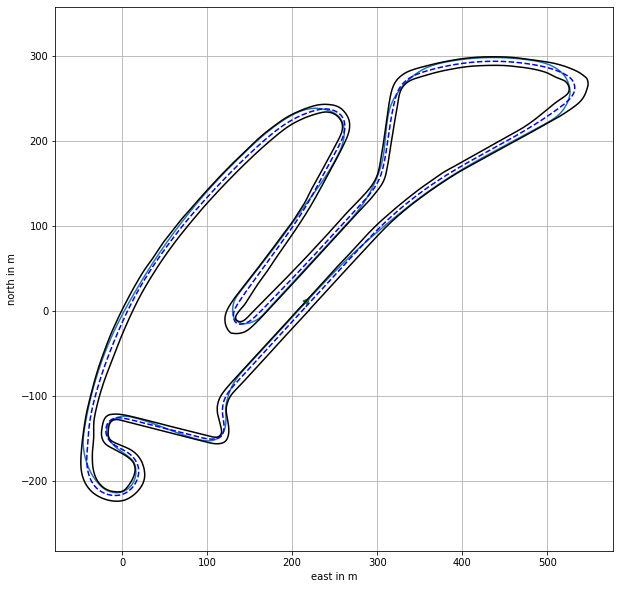

In [23]:
normVec = np.stack((coeffs_y_opt[:, 1], -coeffs_x_opt[:, 1]), axis=1)

# normalize normal vectors
normFactors = 1.0 / np.sqrt(np.sum(np.power(normVec, 2), axis=1))
normvec_normalized_opt = np.expand_dims(normFactors, axis=1) * normVec

bound1 = reftrack_interp[:, :2] + normvec_normalized_opt * np.expand_dims(reftrack_interp[:, 2], 1)
bound2 = reftrack_interp[:, :2] - normvec_normalized_opt * np.expand_dims(reftrack_interp[:, 3], 1)
#bound1_imp = reftrack[:, :2] + normvec_normalized_interp * np.expand_dims(reftrack[:, 2], 1)
#bound2_imp = reftrack[::, :2] - normvec_normalized_interp * np.expand_dims(reftrack[:, 3], 1)

point1_arrow = raceline_interp[0]
point2_arrow = raceline_interp[3]
vec_arrow = point2_arrow - point1_arrow

# plot track including optimized path
plt.figure()
plt.plot(raceline_interp[:, 0], raceline_interp[:, 1])
plt.plot(reftrack_interp[:, 0], reftrack_interp[:, 1],"b--")
plt.plot(bound1[:, 0], bound1[:, 1], "k-")
plt.plot(bound2[:, 0], bound2[:, 1], "k-")


plt.grid()
ax = plt.gca()
ax.arrow(point1_arrow[0], point1_arrow[1], vec_arrow[0], vec_arrow[1],
        head_width=7.0, head_length=7.0, fc='g', ec='g')
ax.set_aspect("equal", "datalim")
plt.xlabel("east in m")
plt.ylabel("north in m")
plt.show()